# Validating the Parametric Analysis in Practice
---
*An investigation of whether the parametric analysis describes practical outcomes from deep learning experiments*

For more background, see the notebook [**Parametric Analysis**](../theory/parametric-analysis.ipynb).

In [1]:
# imports

import json
import warnings

from matplotlib import pyplot as plt
import numpy as np

from experiments.visualization import plot_distribution
from opda.nonparametric import EmpiricalDistribution
from opda.parametric import NoisyQuadraticDistribution
import opda.random

# constants

experiments = {
    "llama-33m_tuning": {
        "family": "llama",
        "model": "Llama 33M",
        "dataset": "SlimPajama-6B",
        "metric": "cross-entropy",
    },
    "deberta-v3-base_tuning": {
        "family": "deberta",
        "model": "DeBERTaV3",
        "dataset": "MultiNLI-m",
        "metric": "error rate",
    },
    "resnet18_tuning": {
        "family": "resnet",
        "model": "ResNet18",
        "dataset": "ImageNet",
        "metric": "error rate",
    },
}

experiment_to_params = {
    # experiment             : (convex, threshold),
    "llama-33m_tuning"       : (  True,     3.695),
    "deberta-v3-base_tuning" : (  True,     0.11 ),
    "resnet18_tuning"        : (  True,     0.325),
}

metric_to_bounds = {
    "cross-entropy": [0., np.inf],
    "error rate": [0., 1.],
}

styles = {
    "empirical": {"linestyle": "--", "color": "#648FFF"},
    "theoretical": {"linestyle": "-", "color": "#FFB000"},
}

ns_grid = np.linspace(1., 128., num=1_024)

n_samples = 48

confidence_gof = 0.95
confidence_extrapolation = 0.80


# Configure environment.

generator = np.random.RandomState(0)
opda.random.set_seed(generator)

warnings.filterwarnings("ignore")


# Configure Matplotlib.

plt.style.use("experiments.default")

## Experimental Design

In this case study, we validate the parametric analysis across three diverse deep learning scenarios.

In each scenario, we sample 1,024 iterations of random search. Using these samples, we can check whether the noisy quadratic distribution accurately describes the score distribution. Afterwards, we'll see how well you can use the noisy quadratic to extrapolate the tuning curve from a small number of search iterations.

### Llama 33M on SlimPajama-6B

**Llama** [(Touvron et al., 2023)](https://arxiv.org/abs/2302.13971) is a standard transformer architecture for language modeling. Language models are trained to predict each word in a document from the ones preceding it. These documents usually come from the web. Together, they constitute a pretraining corpus, like SlimPajama [(Soboleva et al., 2023)](https://www.cerebras.net/blog/slimpajama-a-627b-token-cleaned-and-deduplicated-version-of-redpajama). Such language models are then the first step in creating chat assistants.

We train a 33M parameter llama using a similar recipe as [Hägele et al. (2024)](https://arxiv.org/abs/2405.18392). This recipe uses the [Adam](https://arxiv.org/abs/1412.6980) optimizer with a [warmup-stable-decay (WSD) learning rate schedule](https://arxiv.org/abs/2404.06395) and decaying the learning rate over the last 20% of training. In addition, the model is regularized with both dropout and weight decay.

To tune these hyperparameters, we used the following search distribution:

$$
\begin{align*}
  \mathtt{lr} &\sim \operatorname{LogUniform}(1e{-}5, 1e{-}1) \\
  \mathtt{beta1} &\sim \operatorname{Uniform}(0.7, 1.) \\
  \mathtt{beta2} &\sim \operatorname{Uniform}(0.8, 1.) \\
  \mathtt{warmup\_steps} &\sim \operatorname{DiscreteUniform}(0, 3000) \\
  \mathtt{weight\_decay} &\sim \operatorname{LogUniform}(1e{-}4, 1e0) \\
  \mathtt{dropout} &\sim \operatorname{Uniform}(0., 0.1) \\
\end{align*}
$$

We trained Llama 33M on [SlimPajama-6B](https://huggingface.co/datasets/DKYoon/SlimPajama-6B) (a 6B token subset of SlimPajama) using 1,024 hyperparameter settings sampled from this search distribution. Training used a batch size of 200 and went on for 10k gradient updates, covering about 1B tokens (out of all 6B) per run. Throughout training, we recorded the cross-entropy on a held out validation set every 500 steps. Taking the best cross-entropy that each model achieved during training, this process yields 1,024 validation scores&mdash;one for each hyperparameter configuration.

### DeBERTaV3 on MultiNLI

**DeBERTaV3** [(He et al., 2023)](https://arxiv.org/abs/2111.09543) is a pretrained masked-language model designed for traditional natural language processing tasks. We finetune it to perform natural language inference, to identify whether one sentence entails another. [MultiNLI (Adina et al., 2018)](https://arxiv.org/abs/1704.05426) offers a standard benchmark for this task.

In this analysis, we reuse the DeBERTaV3 hyperparameter tuning results introduced in [Evaluating DeBERTaV3 with the Nonparametric Analysis](./evaluating-debertav3-with-the-nonparametric-analysis.ipynb#The-DeBERTa-Model-Family). We tuned the hyperparameters using the following search distribution:

$$
\begin{align*}
  \mathtt{batch}\_\mathtt{size} &\sim \operatorname{DiscreteUniform}(16, 64) \\
  \mathtt{num}\_\mathtt{epochs} &\sim \operatorname{DiscreteUniform}( 1,  4) \\
  \mathtt{warmup}\_\mathtt{proportion} &\sim \operatorname{Uniform}(0, 0.6) \\
  \mathtt{learning}\_\mathtt{rate} &\sim \operatorname{LogUniform}(10^{-6}, 10^{-3}) \\
  \mathtt{dropout} &\sim \operatorname{Uniform}(0, 0.3) \\
\end{align*}
$$

where $\mathtt{warmup}\_\mathtt{proportion}$ is the number of warmup steps as a proportion of *the first epoch*.

We finetuned DeBERTaV3 on MultiNLI using 1,024 hyperparameter settings sampled from this search distribution. For the validation score, we use the best error rate (one minus the accuracy) obtained on MultiNLI's *matched* validation set during training.

### ResNet18 on ImageNet

**Residual Networks (ResNets)** [(He et al., 2015)](https://arxiv.org/abs/1512.03385) are a standard convolutional neural architecture for computer vision tasks. By using residual connections, they enable training much deeper networks. Often, ResNets are pretrained by teaching them to classify images from the ImageNet benchmark [(Russakovsky et al., 2014)](https://arxiv.org/abs/1409.0575). Once pretrained, these networks can serve as backbones for other architectures or provide sophisticated features for images.

Typically, ResNets are trained using SGD with momentum. To prevent overfitting, it is common to use weight decay (l2 regularization) and label smoothing (averaging the labels with the uniform distribution). Label smoothing can also accelerate training, though perhaps the most effective technique to accelerate training is using a 1-cycle policy with a large learning rate [(Smith and Topin, 2017)](https://arxiv.org/abs/1708.07120). With a 1-cycle policy, the learning rate starts out small, linearly increases to a peak, then linearly decreases, and finally rapidly decays even further. With a 1-cycle policy, ResNets can train to high accuracy almost an order of magnitude faster.

To tune the hyperparameters, we used the following search distribution:

$$
\begin{align*}
  \mathtt{epochs} &\sim \operatorname{DiscreteUniform}(20, 100) \\
  \mathtt{batch}\_\mathtt{size} &\sim \operatorname{DiscreteUniform}(\{128, 256, 512, 1024\}) \\
  \mathtt{lr} &\sim \operatorname{LogUniform}(5e{-}3, 5e1) \\
  \mathtt{lr}\_\mathtt{peak}\_\mathtt{epoch} &= \lfloor\mathtt{proportion} \times \mathtt{epochs}\rfloor,\; \mathtt{proportion} \sim \operatorname{Uniform}(0, 0.8) \\
  \mathtt{momentum} &\sim \operatorname{Uniform}(0.7, 1.0) \\
  \mathtt{weight}\_\mathtt{decay} &\sim \operatorname{LogUniform}(1e{-}6, 1e{-}3) \\
  \mathtt{label}\_\mathtt{smoothing} &\sim \operatorname{Uniform}(0, 0.5) \\
  \mathtt{use}\_\mathtt{blurpool} &\sim \operatorname{DiscreteUniform}(0, 1) \\
\end{align*}
$$

We trained ResNet18 from scratch on ImageNet using 1,024 hyperparameter settings sampled from this search distribution. After each epoch, we evaluated the model on ImageNet's validation set and recorded the top 1 and top 5 accuracy (among other metrics). Thus, we have 1,024 top 1 (and top 5) accuracy numbers on the validation set, each representing a performance achieved with a particular hyperparameter setting. For our metric, we will use the top 1 error rate (one minus the accuracy).

In [2]:
# Load the data.
experiment_to_hparams_and_ys = {}
for experiment in experiments:
    family = experiments[experiment]["family"]
    with open(f"../../data/{family}/{experiment}.results.jsonl") as f_in:
        hparams, ys = [], []
        for ln in f_in:
            ex = json.loads(ln)
            if experiment.startswith("llama-33m"):
                hparams.append({
                    k: v
                    for k, v in ex["hyperparameters"].items()
                    if k not in {
                        # The following hyperparameters were fixed during search.
                        "total_steps",
                        "n_embd",
                        "n_head",
                        "n_layer",
                        "sequence_length",
                        "wsd_fract_decay",
                        "seed",
                        "data_seed",
                    }
                })
                ys.append(min(
                    step["val_raw_loss"] if not np.isnan(step["val_raw_loss"]) else np.inf
                    for step in ex["learning_curve"]
                ))
            elif experiment.startswith("deberta-v3-base"):
                hparams.append({
                    key: ex[key]
                    for key in [
                        "num_train_epochs",
                        "train_batch_size",
                        "learning_rate",
                        "warmup_steps",
                        "cls_drop_out",
                    ]
                })
                ys.append(min(
                    1 - accuracy  # error rate
                    for _, accuracy in ex["learning_curves"]["matched"]
                ))
            elif experiment.startswith("resnet18"):
                hparams.append({
                    key: ex[key]
                    for key in [
                        "epochs",
                        "batch_size",
                        "lr",
                        "lr_peak_epoch",
                        "momentum",
                        "weight_decay",
                        "label_smoothing",
                        "use_blurpool",
                    ]
                })
                ys.append(
                    # Use the best error rate, even if the loss later became NaN.
                    min(1 - epoch["top_1"] for epoch in ex["learning_curve"])
                    if len(ex["learning_curve"]) > 0 else
                    # Otherwise, use 1 if the loss became NaN in the first epoch.
                    1.,
                )
            else:
                raise RuntimeError(f"Unrecognized experiment: {experiment}.")

        experiment_to_hparams_and_ys[experiment] = (hparams, np.array(ys))

# Validate the data.
total_samples = 1_024
for experiment, (hparams, ys) in experiment_to_hparams_and_ys.items():
    # Check the experiment has the expected number of samples.
    if len(hparams) != total_samples or len(ys) != total_samples:
        raise RuntimeError(
            f"{experiment} experiment has the wrong number of examples.",
        )

## Assessing Goodness of Fit

The ultimate test of any theory is how well it explains the data. To explain the data, the theory must first fit it well and then extrapolate correctly to new conditions, while being as simple and interpretable as possible.

Let's test our theory by seeing how well it fits the data. Using the large samples from random search with Llama 33M, DeBERTaV3, and ResNet18, we can compare the empirical score distributions and tuning curves with our theoretical predictions.

Since we're minimizing, the noisy quadratic distributions should all be convex. We've also chosen each threshold for the asymptotic regime, $\theta$, *visually* based on the plots. We'll fit the other parameters to the distributions' tails via [maximum product of spacings estimation (MPS)](https://en.wikipedia.org/wiki/Maximum_spacing_estimation). Maximum spacing estimation is similar to maximum likelihood except that rather than the likelihood, it maximizes the *spacing function*:

$$
\mathcal{S}(\alpha, \beta, \gamma, \sigma; Y_1, \ldots, Y_n) = \prod_{i=1}^{n+1} F\left(Y_{(i)}; \alpha, \beta, \gamma, \sigma\right) - F\left(Y_{(i-1)}; \alpha, \beta, \gamma, \sigma\right)
$$

where $Y_{(i)}$ are the order statistics with $Y_{(0)} = -\infty$ and $Y_{(n+1)} = \infty$.

In regular estimation problems, maximum spacing estimates share the same asymptotic distribution as their maximum likelihood counterparts; however, they fare better in non-regular situations. For example, *the unbounded likelihood problem*&mdash;which affects the noisy quadratic distribution&mdash;makes maximum likelihood estimators inconsistent, while maximum spacing estimators maintain good properties [(Cheng and Traylor, 1995)](https://doi.org/10.1111/j.2517-6161.1995.tb02013.x).

Since we only want to fit to the (left) *tail* of the distributions, we'll use a (right) censored spacing function:

$$
\mathcal{S}(\alpha, \beta, \gamma, \sigma; Y_1, \ldots, Y_n) = \left(1 - F(\theta; \alpha, \beta, \gamma, \sigma)^{n-k}\right) \prod_{i=1}^{k} F\left(Y_{(i)}; \alpha, \beta, \gamma, \sigma\right) - F\left(Y_{(i-1)}; \alpha, \beta, \gamma, \sigma\right)
$$

where $\theta$ is the threshold defining the asymptotic regime and $k$ is the maximal integer such that $Y_{(k)} < \theta$. Intuitively, the formula replaces each censored spacing with the spacing of the whole censored interval: $F\left(\infty; \alpha, \beta, \gamma, \sigma\right) - F\left(\theta; \alpha, \beta, \gamma, \sigma\right) = 1 - F\left(\theta; \alpha, \beta, \gamma, \sigma\right)$.

Llama 33M on SlimPajama-6B
Parameters        : a = 3.580, b = 4.171, c = 1.0, o = 2.8e-02, convex = True
Asymptotic Regime : threshold = 3.695, probability = 43.8%

DeBERTaV3 on MultiNLI-m
Parameters        : a = 0.095, b = 0.141, c = 1.0, o = 1.0e-03, convex = True
Asymptotic Regime : threshold = 0.110, probability = 57.3%

ResNet18 on ImageNet
Parameters        : a = 0.288, b = 0.396, c = 2.0, o = 6.6e-03, convex = True
Asymptotic Regime : threshold = 0.325, probability = 34.3%



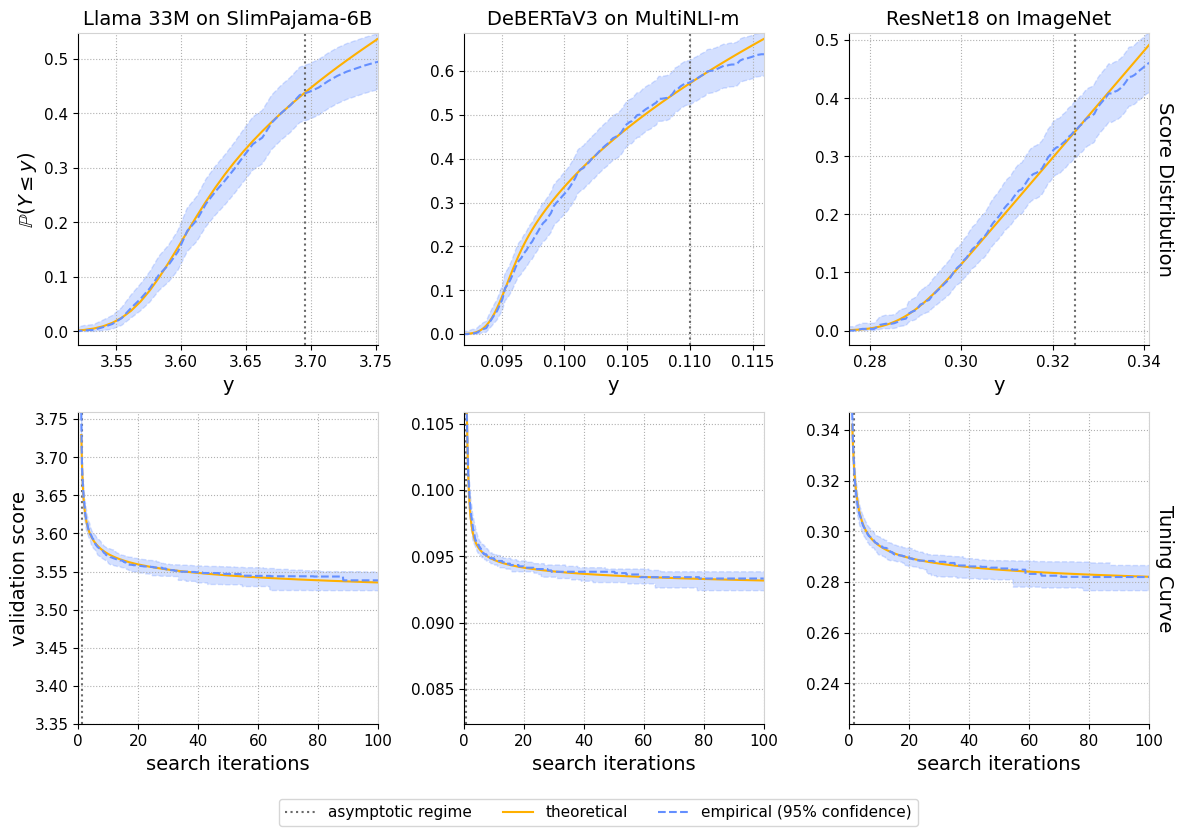

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
for j, experiment in enumerate(experiments):
    hparams, ys = experiment_to_hparams_and_ys[experiment]
    (n_hparams,) = np.unique([len(ex.keys()) for ex in hparams])

    convex, threshold = experiment_to_params[experiment]

    y_min, y_max = metric_to_bounds[experiments[experiment]["metric"]]
    ys_grid = np.linspace(
        y_min, y_min + 2 * (threshold - y_min),
        num=1_024,
    )

    # Compute the nonparametric ground truth.
    dist_lo, dist_pt, dist_hi = EmpiricalDistribution.confidence_bands(
        ys=ys, confidence=confidence_gof,
        a=y_min, b=y_max,
    )

    # Compute the parametric tail approximation.
    dist_tl = NoisyQuadraticDistribution.fit(
        ys,
        limits=(-np.inf, threshold),
        constraints={
            "a": [y_min, y_max],
            "c": (1, n_hparams),
            "convex": convex,
        },
    )

    # Display the approximation's parameters.
    print(
        f"{experiments[experiment]['model']} on {experiments[experiment]['dataset']}\n"
        f"{'=' * (len(experiments[experiment]['model']) + 4 + len(experiments[experiment]['dataset']))}\n"
        f"Parameters        :"
        f" a = {dist_tl.a:.3f},"
        f" b = {dist_tl.b:.3f},"
        f" c = {dist_tl.c},"
        f" o = {dist_tl.o:.1e},"
        f" convex = {dist_tl.convex}"
        f"\n"
        f"Asymptotic Regime :"
        f" threshold = {threshold:.3f},"
        f" probability = {100 * dist_tl.cdf(threshold):.1f}%"
        f"\n",
    )

    # Plot the asymptotic regime.
    #   CDF
    axes[0, j].axvline(
        threshold,
        linestyle=":",
        c="dimgray",
    )
    #   Tuning Curve
    axes[1, j].axvline(
        np.log(0.5) / np.log(1 - dist_tl.cdf(threshold)),
        label="asymptotic regime",
        linestyle=":",
        c="dimgray",
    )

    # Plot the theoretical (parametric) approximation.
    #   CDF
    axes[0, j].plot(
        ys_grid,
        dist_tl.cdf(ys_grid),
        **styles["theoretical"],
    )
    #   Tuning Curve
    axes[1, j].plot(
        ns_grid,
        dist_tl.quantile_tuning_curve(ns_grid),
        label="theoretical",
        **styles["theoretical"],
    )

    # Plot the empirical (nonparametric) ground truth.
    #   CDF
    axes[0, j].plot(
        ys_grid,
        dist_pt.cdf(ys_grid),
        **styles["empirical"],
    )
    axes[0, j].fill_between(
        ys_grid,
        dist_lo.cdf(ys_grid),
        dist_hi.cdf(ys_grid),
        alpha=0.275,
        **styles["empirical"],
    )
    #   Tuning Curve
    axes[1, j].plot(
        ns_grid,
        dist_pt.quantile_tuning_curve(ns_grid, minimize=True),
        label=f"empirical ({100 * confidence_gof:.0f}% confidence)",
        **styles["empirical"],
    )
    axes[1, j].fill_between(
        ns_grid,
        dist_hi.quantile_tuning_curve(ns_grid, minimize=True),
        dist_lo.quantile_tuning_curve(ns_grid, minimize=True),
        alpha=0.275,
        **styles["empirical"],
    )

    # Format the plot.
    y_min_ = np.min(ys)
    y_median_ = np.median(ys)

    x_lim_cdf = (
        y_min_ - 0.025 * (threshold - y_min_),
        y_min_ + 4 / 3 * (threshold - y_min_),
    )
    y_lim_cdf = (-0.025, dist_hi.cdf(x_lim_cdf[1]))

    x_lim_tuning_curve = (0, 100)
    y_lim_tuning_curve = (
        y_median_ - 1.75 * (y_median_ - y_min_),
        y_median_,
    )

    axes[0, j].set_xlim(*x_lim_cdf)
    axes[0, j].set_ylim(*y_lim_cdf)
    axes[0, j].set_xlabel("y")
    axes[0, j].set_title(
        f"{experiments[experiment]['model']} on"
        f" {experiments[experiment]['dataset']}",
    )

    axes[1, j].set_xlim(*x_lim_tuning_curve)
    axes[1, j].set_ylim(*y_lim_tuning_curve)
    axes[1, j].set_xlabel("search iterations")

    for i in range(2):
        axes[i, j].spines["right"].set_color("lightgrey")
        axes[i, j].spines["top"].set_color("lightgrey")

axes[0, 0].set_ylabel(r"$\mathbb{P}\left(Y \leq y\right)$")
axes[1, 0].set_ylabel("validation score")
axes[0, -1].yaxis.set_label_position("right")
axes[0, -1].set_ylabel("Score Distribution", labelpad=18, rotation=270)
axes[1, -1].yaxis.set_label_position("right")
axes[1, -1].set_ylabel("Tuning Curve", labelpad=18, rotation=270)

fig.tight_layout()

axes[1, 1].legend(
    loc="lower center",
    bbox_to_anchor=(0.45, -0.35),
    ncol=3,
)

plt.show()

The theoretical model demonstrates an excellent empirical fit! In all cases the tail approximation remains within the 95% confidence bounds for the true CDF and tuning curve. Moreover, the approximation adheres closely to the empirical estimate.

Another point worth noting is how large the asymptotic regime is. For Llama 33M, DeBERTaV3, and ResNet18, the probability of falling in the asymptotic regime is respectively 43.8%, 57.3%, and 34.3%. That means the asymptotic approximation is already applicable after 1 or 2 iterations of random search&mdash;and for DeBERTaV3 it's applicable right from the very first one!

Let's take a closer look at the Llama 33M model.

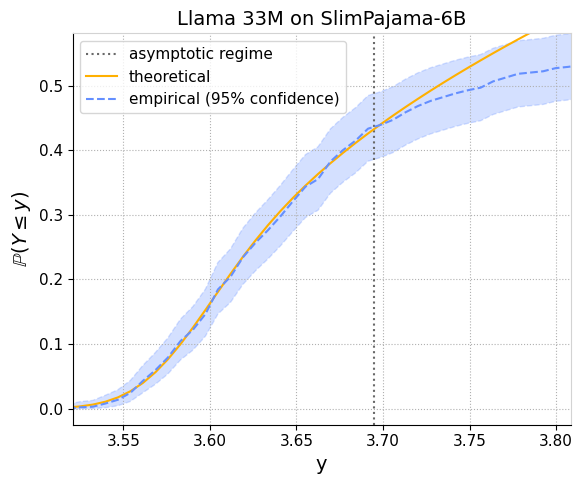

In [4]:
experiment = "llama-33m_tuning"

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

hparams, ys = experiment_to_hparams_and_ys[experiment]
(n_hparams,) = np.unique([len(ex.keys()) for ex in hparams])

convex, threshold = experiment_to_params[experiment]

y_min, y_max = metric_to_bounds[experiments[experiment]["metric"]]
ys_grid = np.linspace(
    y_min, y_min + 2 * (threshold - y_min),
    num=1_024,
)

# Compute the nonparametric ground truth.
dist_lo, dist_pt, dist_hi = EmpiricalDistribution.confidence_bands(
    ys=ys, confidence=confidence_gof,
    a=y_min, b=y_max,
)

# Compute the parametric tail approximation.
dist_tl = NoisyQuadraticDistribution.fit(
    ys,
    limits=(-np.inf, threshold),
    constraints={
        "a": [y_min, y_max],
        "c": (1, n_hparams),
        "convex": convex,
    },
)

# Plot the asymptotic regime.
ax.axvline(
    threshold,
    label="asymptotic regime",
    linestyle=":",
    c="dimgray",
)

# Plot the theoretical (parametric) approximation.
ax.plot(
    ys_grid,
    dist_tl.cdf(ys_grid),
    label="theoretical",
    **styles["theoretical"],
)

# Plot the empirical (nonparametric) ground truth.
ax.plot(
    ys_grid,
    dist_pt.cdf(ys_grid),
    label=f"empirical ({100 * confidence_gof:.0f}% confidence)",
    **styles["empirical"],
)
ax.fill_between(
    ys_grid,
    dist_lo.cdf(ys_grid),
    dist_hi.cdf(ys_grid),
    alpha=0.275,
    **styles["empirical"],
)

# Format the plot.
y_min_ = np.min(ys)

x_lim_cdf = (
    y_min_ - 0.025 * (threshold - y_min_),
    y_min_ + 5 / 3 * (threshold - y_min_),
)
y_lim_cdf = (-0.025, dist_hi.cdf(x_lim_cdf[1]))

ax.set_xlim(*x_lim_cdf)
ax.set_ylim(*y_lim_cdf)
ax.set_xlabel("y")
ax.set_title(
    f"{experiments[experiment]['model']} on"
    f" {experiments[experiment]['dataset']}",
)

ax.spines["right"].set_color("lightgrey")
ax.spines["top"].set_color("lightgrey")

ax.set_ylabel(r"$\mathbb{P}\left(Y \leq y\right)$")

fig.tight_layout()

ax.legend()

plt.show()

Comparing the CDFs close up, we see how tightly the score distribution's tail follows the parametric form. Up until the asymptotic regime's boundary, the two are almost perfectly in sync; past that boundary, they quickly begin to diverge.

While it's important to examine the asymptotic theory's fit for a large number of search iterations, let's take a closer look at the initial parts of those curves.

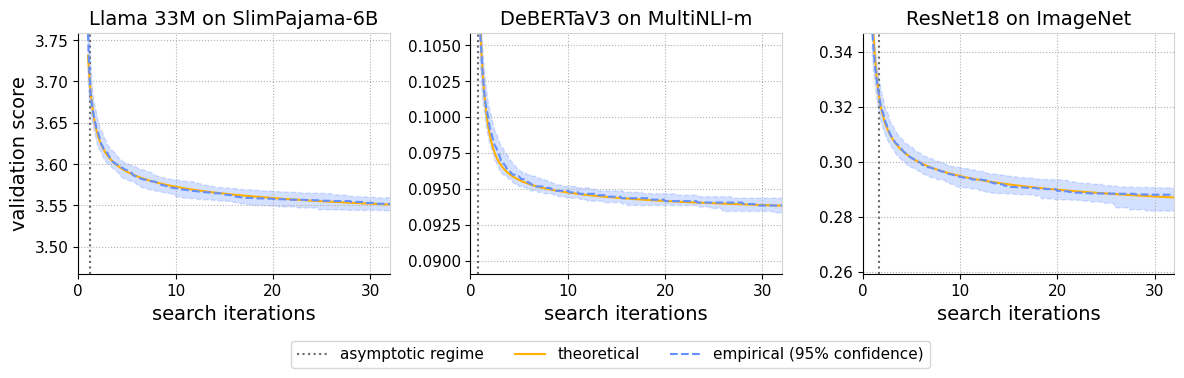

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.5))
for j, experiment in enumerate(experiments):
    hparams, ys = experiment_to_hparams_and_ys[experiment]
    (n_hparams,) = np.unique([len(ex.keys()) for ex in hparams])

    convex, threshold = experiment_to_params[experiment]

    y_min, y_max = metric_to_bounds[experiments[experiment]["metric"]]
    ys_grid = np.linspace(
        y_min, y_min + 2 * (threshold - y_min),
        num=1_024,
    )

    # Compute the nonparametric ground truth.
    dist_lo, dist_pt, dist_hi = EmpiricalDistribution.confidence_bands(
        ys=ys, confidence=confidence_gof,
        a=y_min, b=y_max,
    )

    # Compute the parametric tail approximation.
    dist_tl = NoisyQuadraticDistribution.fit(
        ys,
        limits=(-np.inf, threshold),
        constraints={
            "a": [y_min, y_max],
            "c": (1, n_hparams),
            "convex": convex,
        },
    )

    # Plot the asymptotic regime.
    #   Tuning Curve
    axes[j].axvline(
        np.log(0.5) / np.log(1 - dist_tl.cdf(threshold)),
        label="asymptotic regime",
        linestyle=":",
        c="dimgray",
    )

    # Plot the theoretical (parametric) approximation.
    #   Tuning Curve
    axes[j].plot(
        ns_grid,
        dist_tl.quantile_tuning_curve(ns_grid),
        label="theoretical",
        **styles["theoretical"],
    )

    # Plot the empirical (nonparametric) ground truth.
    #   Tuning Curve
    axes[j].plot(
        ns_grid,
        dist_pt.quantile_tuning_curve(ns_grid, minimize=True),
        label=f"empirical ({100 * confidence_gof:.0f}% confidence)",
        **styles["empirical"],
    )
    axes[j].fill_between(
        ns_grid,
        dist_hi.quantile_tuning_curve(ns_grid, minimize=True),
        dist_lo.quantile_tuning_curve(ns_grid, minimize=True),
        alpha=0.275,
        **styles["empirical"],
    )

    # Format the plot.
    y_min_ = np.min(ys)
    y_median_ = np.median(ys)

    x_lim_tuning_curve = (0, 32)
    y_lim_tuning_curve = (
        y_median_ - 1.25 * (y_median_ - y_min_),
        y_median_,
    )

    axes[j].set_xlim(*x_lim_tuning_curve)
    axes[j].set_ylim(*y_lim_tuning_curve)
    axes[j].set_xlabel("search iterations")
    axes[j].set_title(
        f"{experiments[experiment]['model']} on"
        f" {experiments[experiment]['dataset']}",
    )

    axes[j].spines["right"].set_color("lightgrey")
    axes[j].spines["top"].set_color("lightgrey")

axes[0].set_ylabel("validation score")

fig.tight_layout()

axes[1].legend(
    loc="lower center",
    bbox_to_anchor=(0.45, -0.42),
    ncol=3,
)

plt.show()

While the effect is somewhat subtle, we see that both Llama 33M and DeBERTaV3 tune faster than ResNet for the search spaces we've chosen. While Llama 33M and DeBERTaV3 hit diminishing returns around 10 iterations, ResNet continues seeing steady improvement through 10 or even 15. The reason for this difference comes down to the effective number of hyperparameters. While Llama 33M and DeBERTaV3 have 1, ResNet18 has 2, making the search higher dimensional and thus more difficult.

## Extrapolating Random Search

Beyond explaining the data, we wish to extrapolate it. Let's investigate extrapolating the tuning curve using a small number of samples from random search.

Before we approximate the tail of the score distribution, it's helpful to visualize it. Visualizing the distribution serves two purposes. First, we can judge whether the tail approximation is appropriate in our use case. It's always good to check the assumptions of your analysis with these kinds of visual diagnostics. Even though our limit theorem applies under fairly broad assumptions, a few issues could crop up. For example, the asymptotic regime could be very small or the expected performance could be a discontinuous function of the hyperparameters. The visualization's second purpose is to determine a threshold where the asymptotic regime begins. While the threshold could be determined using automatic methods, the visual approach is the simplest and a good starting point.

So, what do the distributions look like, if we estimate them with small samples?

In [6]:
# Draw the indices defining the subsample.
subsample = generator.choice(1_024, size=n_samples, replace=False)

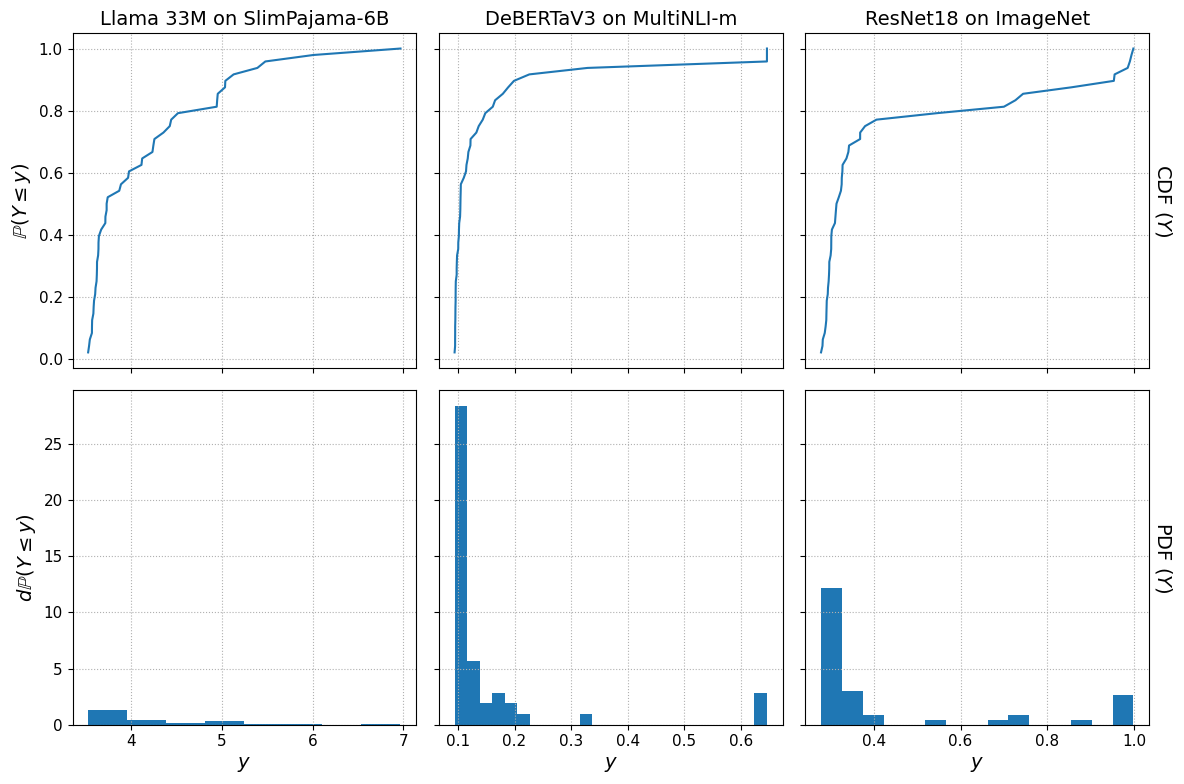

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharex="col", sharey="row")
for j, experiment in enumerate(experiments):
    _, ys = experiment_to_hparams_and_ys[experiment]

    ys_subsample = ys[subsample]

    plot_distribution(ys_subsample, "Y", axes=axes[:, j])

# Format the plot.
for i in range(2):
    axes[i, 1].set_ylabel(None)
    axes[i, -1].yaxis.set_label_position("right")
    axes[i, -1].set_ylabel(axes[i, -1].get_title(), labelpad=18, rotation=270)

for j, experiment in enumerate(experiments):
    axes[0, j].set_xlabel(None)
    axes[0, j].set_title(
        f'{experiments[experiment]["model"]} on'
        f' {experiments[experiment]["dataset"]}',
    )
    axes[1, j].set_title(None)

fig.tight_layout()

plt.show()

We see many hyperparameter configurations give good performance, but a small percentage essentially fail to train.

Let's zoom in on the distributions' tails.

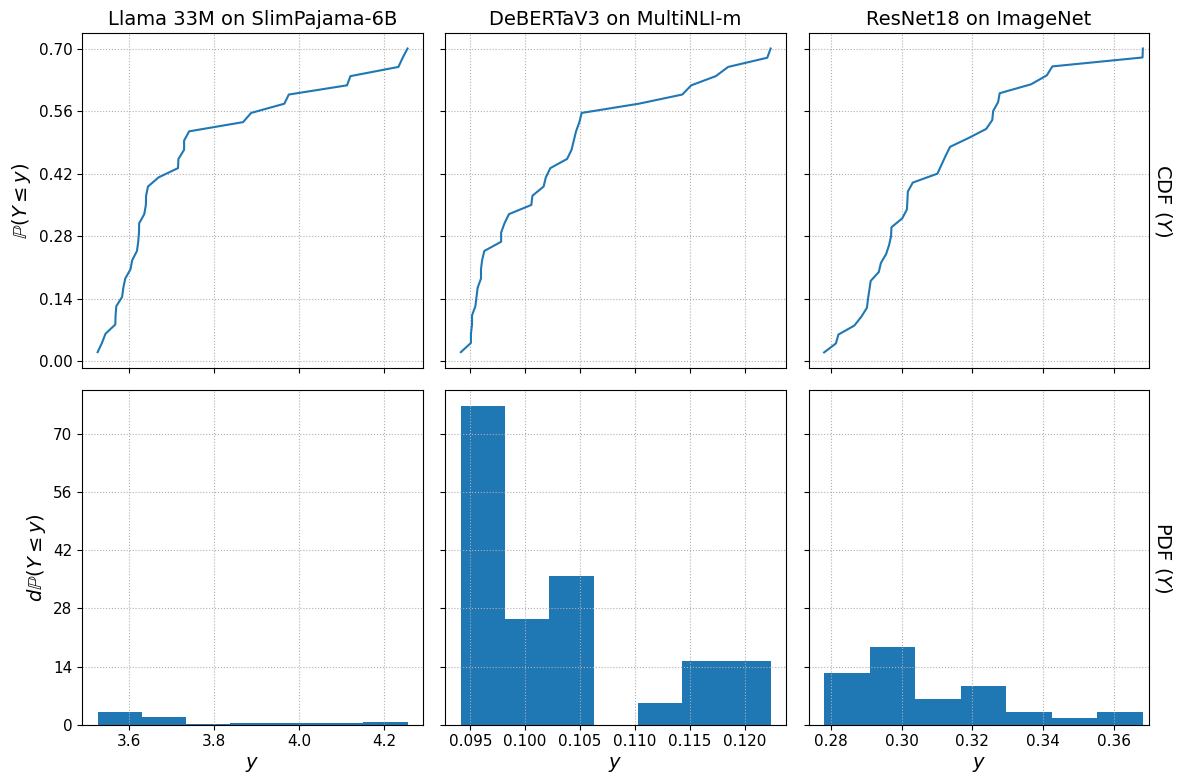

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharex="col", sharey="row")
for j, experiment in enumerate(experiments):
    _, ys = experiment_to_hparams_and_ys[experiment]

    ys_subsample = ys[subsample]

    x_lo, x_hi = np.min(ys_subsample), np.quantile(ys_subsample, 0.7)
    x_lo, x_hi = x_lo - 0.05 * (x_hi - x_lo), x_hi + 0.05 * (x_hi - x_lo)
    for ax in axes[:, j]:
        ax.set_xlim(x_lo, x_hi)

    # Use only samples in the tail to make the plot.
    plot_distribution(ys_subsample[ys_subsample < x_hi], "Y", axes=axes[:, j])

# Format the plot.
for i in range(2):
    axes[i, 1].set_ylabel(None)
    axes[i, -1].yaxis.set_label_position("right")
    axes[i, -1].set_ylabel(axes[i, -1].get_title(), labelpad=18, rotation=270)

for j, experiment in enumerate(experiments):
    axes[0, j].set_xlabel(None)
    axes[0, j].set_title(
        f'{experiments[experiment]["model"]} on'
        f' {experiments[experiment]["dataset"]}',
    )
    axes[1, j].set_title(None)

# Adjust the axes since we filtered to only samples in the tail.
axes[0, 0].set_yticklabels([
    f"{tick:.2f}"
    for tick in 0.7 * axes[0, 0].get_yticks()
])
axes[1, 0].set_yticklabels([
    f"{tick:.0f}"
    for tick in 0.7 * axes[1, 0].get_yticks()
])

fig.tight_layout()

plt.show()

In general, we'd suspect that the number of effective hyperparameters ($\gamma$) is small, for example 1 to 3. If $\gamma = 1$ then the CDF's tail will curve downwards, if $\gamma = 2$ it will be mostly straight, and if $\gamma = 3$ it will curve upwards. If $\gamma > 3$, then the tail will curve strongly upwards and random search will be a poor approach for tuning the hyperparameters.

For Llama 33M, we see a kink in the CDF between 3.65 and 3.7 cross-entropy; DeBERTaV3 appears to have a downward facing curve until about a 10.4% error rate; and ResNet18's CDF seems mostly flat until just past a 30% error rate. When identifying the threshold, it's better to place the threshold too deep in the tail than not deep enough because missing a data point will harm the estimate less than including data points that fit the parametric family poorly.

Thus, our thresholds are 3.66 for Llama 33M, 0.104 for DeBERTaV3, and 0.302 for ResNet18. These thresholds don't perfectly match our estimates based on all the data; however, they're close and hopefully good enough to see some extrapolation. In addition to our thresholds, we could guess the effective number of hyperparameters, $\gamma$; however, it's difficult to distinguish the different CDF shapes visually with so little data. So, instead we'll choose $\gamma$ via maximum spacing estimation, along with the other parameters.

In [9]:
# Set thresholds for the experiments based on the subsample.
experiment_to_threshold = {
    "llama-33m_tuning": 3.66,
    "deberta-v3-base_tuning": 0.104,
    "resnet18_tuning": 0.302,
}

Now that we've estimated where the asymptotic regime starts, let's try to fit and extrapolate the tuning curves.

To obtain a point estimate, we can fit a noisy quadratic distribution to the asymptotic regime. Since we want as efficient an estimate as possible, we'll leverage our knowledge about the problem to constrain and improve the fit. First, we know that cross-entropy is bounded from 0 to $\infty$ and error rate is bounded between 0 and 1. Thus, the average performance of the best hyperparameters must obey these bounds as well. For Llama 33M, $0 \leq \alpha \leq \infty$. For DeBERTaV3 and ResNet18, $0 \leq \alpha \leq 1$. Moreover, the number of effective hyperparameters, $\gamma$, can be at most the number of nominal hyperparameters.

To quantify the uncertainty in our fit, we'll compute confidence bands for each estimate. These confidence bands will tighten our nonparametric confidence bands by throwing out every CDF within them that's *not* a member of the noisy quadratic distribution. Thus, assuming the true (asymptotic) distribution is a noisy quadratic, the bands will have the same coverage. Viewing the nonparametric CDF bands as a goodness-of-fit test, confidence bands and intervals constructed in this way are occasionally called *consonance* intervals [(Easterling, 1976)](https://doi.org/10.2307/1267910).

We compute these confidence bands via a brute-force approach. Namely, we iterate over a grid of parameters, test if each distribution falls inside the nonparametric CDF bands over the asymptotic regime, and then use it to update the parametric CDF bands. In other words, as we iterate, we compute the union of all the CDFs by taking the max of each with the upper bound and the min with the lower bound. We then combine these parametric CDF bands inside the asymptotic regime with the nonparametric ones outside of it. Finally, we use the computed CDF bands to create tuning curve bands as well.

Llama 33M on SlimPajama-6B
Parameters        : a = 3.569, b = 4.135, c = 1.0, o = 3.9e-02, convex = True
Asymptotic Regime : threshold = 3.660, probability = 38.9%

DeBERTaV3 on MultiNLI-m
Parameters        : a = 0.095, b = 0.141, c = 1.0, o = 6.4e-04, convex = True
Asymptotic Regime : threshold = 0.104, probability = 44.7%

ResNet18 on ImageNet
Parameters        : a = 0.286, b = 0.328, c = 2.0, o = 8.9e-03, convex = True
Asymptotic Regime : threshold = 0.302, probability = 38.8%



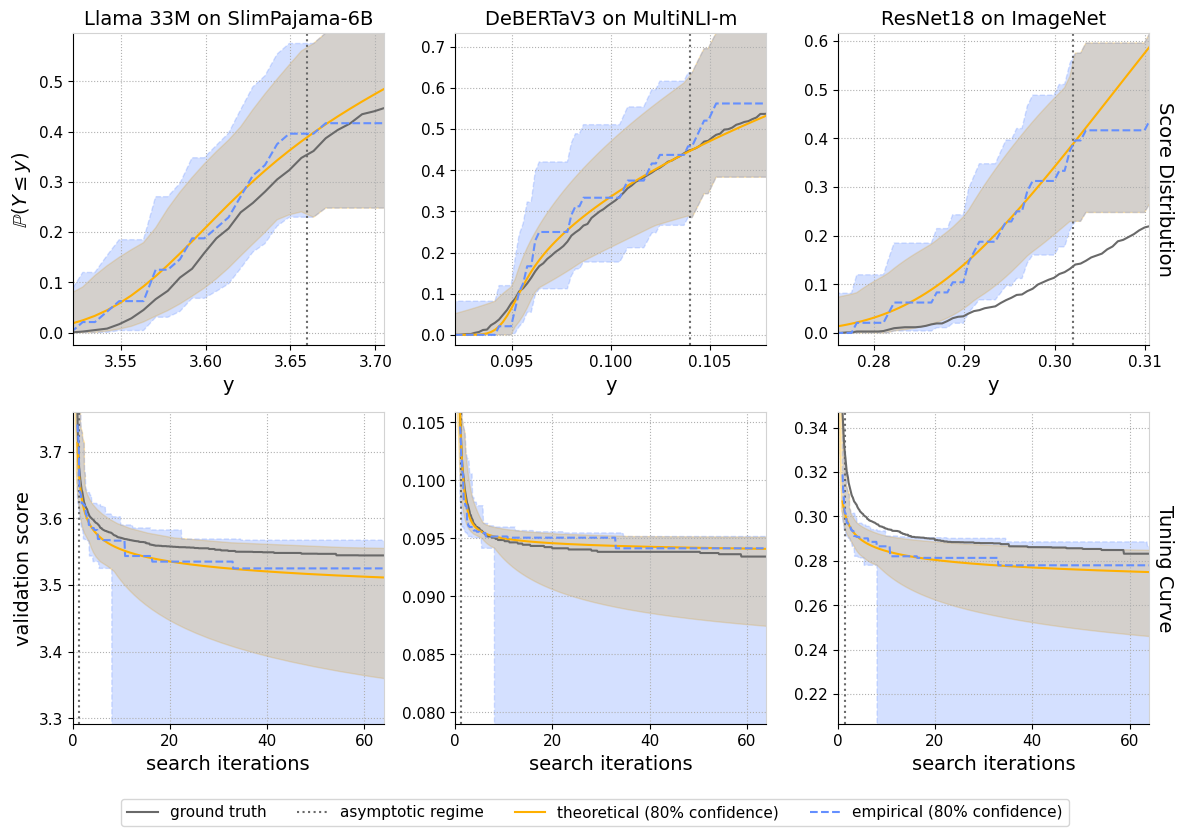

In [10]:
experiment_to_bounds = {
    "llama-33m_tuning": {
        "a": ( 3.24,  3.77),
        "b": ( 3.64,  6.13),
        "o": ( 1e-7, 0.163),
    },
    "deberta-v3-base_tuning" : {
        "a": (0.082, 0.097),
        "b": (0.107, 0.223),
        "o": ( 1e-7, 0.002),
    },
    "resnet18_tuning": {
        "a": (0.197, 0.311),
        "b": (0.301, 0.796),
        "o": ( 1e-7, 0.014),
    },
}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
for j, experiment in enumerate(experiments):
    hparams, ys = experiment_to_hparams_and_ys[experiment]
    (n_hparams,) = np.unique([len(ex.keys()) for ex in hparams])

    convex, _ = experiment_to_params[experiment]
    threshold = experiment_to_threshold[experiment]
    bounds = experiment_to_bounds[experiment]

    y_min, y_max = metric_to_bounds[experiments[experiment]["metric"]]
    ys_grid = np.linspace(
        y_min, y_min + 2 * (threshold - y_min),
        num=1_024,
    )

    ys_subsample = ys[subsample]

    # Compute the nonparametric ground truth.
    dist_all = EmpiricalDistribution(
        ys=ys,
        a=y_min, b=y_max,
    )

    # Compute the nonparametric estimate.
    dist_lo, dist_pt, dist_hi = EmpiricalDistribution.confidence_bands(
        ys=ys_subsample, confidence=confidence_extrapolation,
        a=y_min, b=y_max,
    )

    # Compute the parametric tail approximation.
    #   point estimate
    dist_tl = NoisyQuadraticDistribution.fit(
        ys_subsample,
        limits=(-np.inf, threshold),
        constraints={
            "a": [y_min, y_max],
            "c": (1, n_hparams),
            "convex": convex,
        },
    )
    #   confidence bands
    cdf_min = np.ones_like(ys_grid)
    cdf_max = np.zeros_like(ys_grid)
    # The tuning curve is much more expensive to evaluate than the CDF. To avoid
    # evaluating the tuning curve, compute only the CDF bands and then use them
    # to also plot the tuning curve bands. This approach offers a sizable speed
    # up over directly computing both the CDF and the tuning curve bands.
    for c in range(1, n_hparams + 1):
        for o in np.logspace(*np.log10(bounds["o"]), num=64):
            for a in np.linspace(*bounds["a"], num=128):
                for b in np.linspace(*bounds["b"], num=256):
                    if a >= b:
                        continue

                    dist = NoisyQuadraticDistribution(a, b, c, o, convex)

                    # NOTE: Since the nonparametric confidence bands are step
                    # functions and the CDF is monotonic, we can check that a
                    # CDF falls within the bands by just testing at where the
                    # bands jump up. The bands are upper semicontinuous, so at
                    # the jump points we only need to check the CDF is greater
                    # than or equal to the lower band's value at the jump point,
                    # and less than or equal to upper band's value at the
                    # *previous* jump point.
                    #
                    # As we only care about the asymptotic regime, we only
                    # check for violations within it. This necessitates also
                    # checking for a violation at the threshold (as well as
                    # the CDF bands' jump points in the asymptotic regime).
                    ys_test = np.concatenate([
                        [y_min],
                        np.sort(ys_subsample[ys_subsample < threshold]),
                        [threshold],
                    ])
                    ps = dist.cdf(ys_test[1:])
                    if (
                        np.any(ps < dist_lo.cdf(ys_test[1:]))
                        or np.any(ps > dist_hi.cdf(ys_test[:-1]))
                    ):
                        continue

                    if (
                        a in bounds["a"]
                        or b in bounds["b"]
                        or o == np.max(bounds["o"])
                    ):
                        # If a point on the grid's boundary falls within the
                        # bands, then the grid is too small. We don't need to
                        # check the lower value of o though, because all small
                        # values of o look essentially like the noiseless
                        # quadratic distribution (and there are no more values
                        # of o below that).
                        raise RuntimeError(
                            "The grid's boundary contains a point inside the"
                            " confidence bands.",
                        )

                    cdf = dist.cdf(ys_grid)

                    cdf_min = np.minimum(cdf, cdf_min)
                    cdf_max = np.maximum(cdf, cdf_max)
    # Outside of the asymptotic regime, use the nonparametric bands.
    cdf_min[ys_grid >= threshold] = dist_lo.cdf(ys_grid[ys_grid >= threshold])
    cdf_max[ys_grid >= threshold] = dist_hi.cdf(ys_grid[ys_grid >= threshold])

    # Display the approximation's parameters.
    print(
        f"{experiments[experiment]['model']} on {experiments[experiment]['dataset']}\n"
        f"{'=' * (len(experiments[experiment]['model']) + 4 + len(experiments[experiment]['dataset']))}\n"
        f"Parameters        :"
        f" a = {dist_tl.a:.3f},"
        f" b = {dist_tl.b:.3f},"
        f" c = {dist_tl.c},"
        f" o = {dist_tl.o:.1e},"
        f" convex = {dist_tl.convex}"
        f"\n"
        f"Asymptotic Regime :"
        f" threshold = {threshold:.3f},"
        f" probability = {100 * dist_tl.cdf(threshold):.1f}%"
        f"\n",
    )

    # Plot the empirical (nonparametric) ground truth.
    #   CDF
    axes[0, j].plot(
        ys_grid,
        dist_all.cdf(ys_grid),
        linestyle="-",
        c="dimgray",
    )
    #   Tuning Curve
    axes[1, j].plot(
        ns_grid,
        dist_all.quantile_tuning_curve(ns_grid, minimize=True),
        label="ground truth",
        linestyle="-",
        c="dimgray",
    )

    # Plot the asymptotic regime.
    #   CDF
    axes[0, j].axvline(
        threshold,
        linestyle=":",
        c="dimgray",
    )
    #   Tuning Curve
    axes[1, j].axvline(
        np.log(0.5) / np.log(1 - dist_tl.cdf(threshold)),
        label="asymptotic regime",
        linestyle=":",
        c="dimgray",
    )

    # Plot the theoretical (parametric) approximation.
    #   CDF
    axes[0, j].plot(
        ys_grid,
        dist_tl.cdf(ys_grid),
        **styles["theoretical"],
    )
    axes[0, j].fill_between(
        ys_grid,
        cdf_min,
        cdf_max,
        alpha=0.275,
        **styles["theoretical"],
    )
    #   Tuning Curve
    axes[1, j].plot(
        ns_grid,
        dist_tl.quantile_tuning_curve(ns_grid),
        label=f"theoretical ({100 * confidence_extrapolation:.0f}% confidence)",
        **styles["theoretical"],
    )
    axes[1, j].fill_betweenx(
        ys_grid,
        np.log(0.5) / np.log(1 - cdf_max),
        np.minimum(
            # When cdf_min == 0, np.log(1 - cdf_min) is +0, and thus
            # np.log(0.5) / np.log(1 - cdf_min) is negative infinity. Conceptually,
            # cdf_min -> 1 from below, so it approaches 0 from the left (i.e., -0).
            # Thus, log(0.5) / log(1 - cdf_min) should really be positive infinity.
            # Therefore, take the absolute value. Also, clip the result to be at most
            # the maximum from ns_grid since fill_betweenx can't handle infinities.
            np.max(ns_grid),
            np.abs(np.log(0.5) / np.log(1 - cdf_min)),
        ),
        alpha=0.275,
        **styles["theoretical"],
    )

    # Plot the empirical (nonparametric) estimate.
    #   CDF
    axes[0, j].plot(
        ys_grid,
        dist_pt.cdf(ys_grid),
        **styles["empirical"],
    )
    axes[0, j].fill_between(
        ys_grid,
        dist_lo.cdf(ys_grid),
        dist_hi.cdf(ys_grid),
        alpha=0.275,
        **styles["empirical"],
    )
    #   Tuning Curve
    axes[1, j].plot(
        ns_grid,
        dist_pt.quantile_tuning_curve(ns_grid, minimize=True),
        label=f"empirical ({100 * confidence_extrapolation:.0f}% confidence)",
        **styles["empirical"],
    )
    axes[1, j].fill_between(
        ns_grid,
        dist_hi.quantile_tuning_curve(ns_grid, minimize=True),
        dist_lo.quantile_tuning_curve(ns_grid, minimize=True),
        alpha=0.275,
        **styles["empirical"],
    )

    # Format the plot.
    y_min_ = np.min(ys)
    y_median_ = np.median(ys)

    x_lim_cdf = (
        y_min_ - 0.025 * (threshold - y_min_),
        y_min_ + 4 / 3 * (threshold - y_min_),
    )
    y_lim_cdf = (-0.025, dist_hi.cdf(x_lim_cdf[1]))

    x_lim_tuning_curve = (0, 64)
    y_lim_tuning_curve = (
        y_median_ - 2 * (y_median_ - y_min_),
        y_median_,
    )

    axes[0, j].set_xlim(*x_lim_cdf)
    axes[0, j].set_ylim(*y_lim_cdf)
    axes[0, j].set_xlabel("y")
    axes[0, j].set_title(
        f"{experiments[experiment]['model']} on"
        f" {experiments[experiment]['dataset']}",
    )

    axes[1, j].set_xlim(*x_lim_tuning_curve)
    axes[1, j].set_ylim(*y_lim_tuning_curve)
    axes[1, j].set_xlabel("search iterations")

    for i in range(2):
        axes[i, j].spines["right"].set_color("lightgrey")
        axes[i, j].spines["top"].set_color("lightgrey")

axes[0, 0].set_ylabel(r"$\mathbb{P}\left(Y \leq y\right)$")
axes[1, 0].set_ylabel("validation score")
axes[0, -1].yaxis.set_label_position("right")
axes[0, -1].set_ylabel("Score Distribution", labelpad=18, rotation=270)
axes[1, -1].yaxis.set_label_position("right")
axes[1, -1].set_ylabel("Tuning Curve", labelpad=18, rotation=270)

fig.tight_layout()

axes[1, 1].legend(
    loc="lower center",
    bbox_to_anchor=(0.45, -0.35),
    ncol=4,
)

plt.show()

The parametric bands dramatically improve the nonparametric ones. They smooth and tighten the nonparametric bands over the entire domain. Moreover, while the nonparametric bands eventually become trivial, the parametric ones successfully extrapolate the confidence bounds up to the full size of the original sample and beyond.

In contrast, the parametric point estimates are smoother than the nonparametric ones, but overall look fairly similar. This similarity is due to the effectiveness of random search. As our theory reveals, the difficulty of random search is determined by the effective number of hyperparameters, $\gamma$. For Llama 33M, DeBERTaV3, ResNet18, and many other models, the effective number of hyperparameters is low&mdash;1 or 2. As a result, only a few iterations are necessary to obtain near optimal performance. For example, if $\gamma = 1$ the model will tune so quickly that perhaps 4 or 5 iterations will be sufficient, with performance saturating after about 6 to 10. Thus, even a modest sample reveals much of the tuning curve's shape. In such cases hyperparameter tuning is easy&mdash;and by fitting the parametric form and plotting the tuning curve, you can tell if you are so lucky!

At the same time, it's still possible to fall short of that optimal performance, so uncertainty quantification remains as important as ever. For Llama 33M, we see the estimated tuning curve falls above the true one; however, the confidence bands still contain it. For ResNet18, the curve falls above the true one and indeed outside the confidence bands. At 80% confidence, it's unsurprising that this happened for one of the three models. Of course, one could use a higher confidence level if appropriate for the application.

## Conclusion

We saw that the asymptotic theory accurately describes the score distribution in real-world scenarios. Using the parametric analysis, you can then extrapolate confidence bands for the tuning curve.

Besides the confidence bands we explore here, you can also perform inference on *any* of the noisy quadratic distribution's parameters using standard statistical techniques. For example, you could test the hypothesis that there's one effective hyperparameter, construct a confidence interval for the best possible performance, or estimate an upper bound for the residual noise (e.g., using a likelihood ratio test).

In this way, the parametric analysis provides new tools for quantifying uncertainty in experiments, and for better understanding the hyperparameter loss surface.